# Assignment 2 (Recognize Animals)

- #### Objective:
    - Train deep learning model that would recognize the name of the animal from its images
        - The model should be able to recognize and differentiate between 5 animals
        - 5 categories/classes: butterfly, sheep, cow, squirrel, elephant:
        - mucca (cow), pecora (sheep), elefante (elephant), farfalla (butterfly) and scoiattolo (squirrel)


- In this notebook TASK 1, TASK 2 and some portion of TASK 5 (splitting training images into train and validation set) are perfomed. Details of the tasks perfomed:

    - #### Loading the train and test images and converting them into arrays
    
    - #### Apply preprocessing steps:
        - Resize images - Justification: Neural Network will expected inputs of the same size. Therefore, all images need to be resized to a fixed size before inputting them to Neural Network (Chosen size was (128, 128))
        - Convert all images to same color mode: Justification: All the images will be in the same desired color mode that we expect from the out of samples images (Chosen color mode was RGB)
        - Sacaling (normalize) the image so that pixel values will be between 0 and 1
            - Justification:
                1) Improve the speed of model training
                2) Pixel magnitudes will be uniform for the images
    
    - #### Display sample images along with its corresponsing labels
    
    - #### Spliting the training data into train and validation set with ratio of 80:20 (i.e. 80% train and 20% validation)
    
    - #### Save the arrays representing the images as pickle file - to be used for building the models in the subsequent notebooks/steps


## Import Libraries

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split, KFold, ParameterSampler
from sklearn.metrics import confusion_matrix, classification_report

from PIL import Image
import glob
import cv2
import os
import datetime
import pathlib
import pickle

# Load the TensorBoard notebook extension
%load_ext tensorboard

## Task 1: Loading Data
- Load the data and save it in appropriate variables. Display an image and its corresponding label.

In [2]:
# Train Data directory
data_dir = os.path.join(os.getcwd(), 'animal_dataset_intermediate', 'train')
data_dir = pathlib.Path(data_dir)

# Parameters (Desired height and width of images) [Images will be resized to specified height and width]
height = 128
width = 128


In [3]:
# Determine the type of image file extensions (e.g. jpg, jpeg, png, etc.) that exists in the provided train image dataset
# Will be used to filter out non-image file exists in the folder (e.g. to filter out txt file in the provided train image folder)

possible_ext = []
for class_name in os.listdir(data_dir):
    possible_ext.extend([os.path.splitext(filename)[1][1:] for filename in os.listdir(os.path.join(data_dir, class_name))])

possible_ext = list(set(possible_ext))


In [4]:
# Count the total number of images present in the train image dataset
image_count = 0
for ext in list(possible_ext):
    if ext=='txt':
        continue
    image_count = image_count + len(list(data_dir.glob('*/*.{}'.format(ext))))


In [5]:
# Function to Read Images from the folder and converting into array after resizing and converting them into desired color mode

def image_to_array(data_dir, exts, total_images, height=256, width=256, channel=3):
    dataset = np.zeros((total_images, height, width, channel))
    y_train = np.zeros((total_images, 1), dtype=int)
    y_train_labels = np.zeros((total_images, 1), dtype=object)
    
    class_names = os.listdir(data_dir) #[x.split('_')[0] for x in os.listdir(data_dir)]
    j = 0
    idx_to_class = dict()
    for i, class_name in enumerate(class_names):
        idx_to_class[i] = class_name.split('_')[0]
        for ext in exts:
            for filename in glob.glob(os.path.join(data_dir, class_name, "*.{}".format(ext))):
                if ext=="txt":
                    continue
                
                im = Image.open(filename)
                im = im.resize((height, width))
                pixels = np.asarray(im).astype('float32')
                
                if len(pixels.shape)==2:
                    pixels = cv2.cvtColor(pixels, cv2.COLOR_GRAY2BGR)
                
                if pixels.shape[2]!=channel:
                    #pixels = cv2.cvtColor(pixels, cv2.COLOR_BGRA2RGB)
                    pixels = cv2.cvtColor(pixels, cv2.COLOR_RGBA2RGB)
                
                pixels /= 255.0
                
                dataset[j, :, :, :] = pixels
                y_train[j, :] = i
                y_train_labels[j, :] = class_name.split('_')[0]
                
                j += 1
    
    return dataset, y_train, y_train_labels, idx_to_class
                

In [6]:
# Load Images from training image folder using the 'image_to_array' function defined earlier
X_train, y_train, y_train_labels, idx_to_class = image_to_array(data_dir=data_dir, exts=possible_ext, 
                                                                total_images=image_count, height=height, 
                                                                width=width)


In [7]:
# Understanding the Data 
# Get an idea on the number of samples for each class (Whether we are dealing with extremely imbalanced classes)
# Print out the findings
print(f"Total number of training dataset: {len(X_train)}")
print(f"Shape of Train: {X_train.shape}")

unique_elements, counts_elements = np.unique(y_train_labels, return_counts=True)

print(f"Number of classes: {len(unique_elements)}")
print("\n")

print(f'''Number of train samples by class: 
Class Labels: {unique_elements}
Number of Samples: {counts_elements}''')
print("\n")

Total number of training dataset: 8196
Shape of Train: (8196, 128, 128, 3)
Number of classes: 5


Number of train samples by class: 
Class Labels: ['elefante' 'farfalla' 'mucca' 'pecora' 'scoiattolo']
Number of Samples: [1301 1901 1680 1638 1676]




#### Comments:
- There are 8196 images in the train folder.
- Number of samples for 'elefante' class appear to less than other class and samples for 'farfalla' appear to be more than other samples.
- If in later stages, the model performance was poor in terms of recall and F-1 score (model favors majority classes) - should consider using techniques to handle imbalance in the dataset like oversampling, undersampling, combination of oversampling and undersampling, weighted random sampler, etc.

### View Sample Image from Each Class

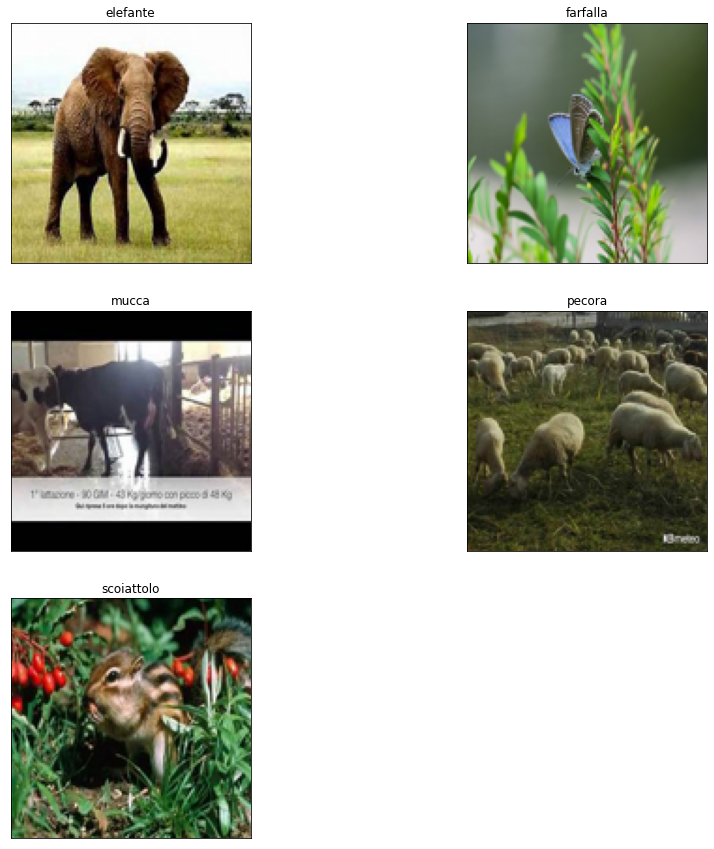

In [8]:
class_names = unique_elements

fig = plt.figure(figsize=(15, 15))
for i in range(len(class_names)):
    ax = fig.add_subplot(3, 2, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::], (0, 1, 2))
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### View A Single Sample Image

In [9]:
def show_sample_image(X_train, y_train, image_id):
    print(f"Class Label: {y_train[image_id]}")
    print(f"Label Name: {y_train_labels[image_id]}")
    plt.imshow(X_train[image_id]);

Class Label: [0]
Label Name: ['elefante']


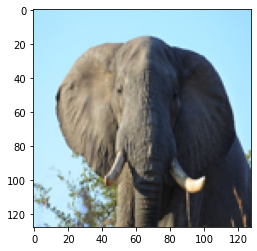

In [10]:
# View Some Sample Images
show_sample_image(X_train, y_train, image_id=50)

### Load Test Data
- Loading and preparing test data, so that will be easier to generate output for submission later

In [11]:
# Read Test List
test_list = pd.read_csv(os.path.join(os.path.dirname(data_dir), "Testing_set_animals.csv"))
test_filename = list(test_list["filename"].values)
total_images = len(test_filename)

# Define Test Dir
test_dir = os.path.join(os.path.dirname(data_dir), 'test')

In [12]:
# Function to read and convert test images to array (Slightly modified version of the previous image_to_array function)

def test_image_to_array(test_dir, test_filename, total_images, height=256, width=256, channel=3):
    dataset = np.zeros((total_images, height, width, channel))
    
    for i, file_name in enumerate(test_filename):
        img_dir = os.path.join(test_dir, file_name)
        
        im = Image.open(img_dir)
        im = im.resize((height, width))
        pixels = np.asarray(im).astype('float32')
        
        if len(pixels.shape)==2:
            pixels = cv2.cvtColor(pixels, cv2.COLOR_GRAY2RGB)
        
        if pixels.shape[2]!=channel:
            pixels = cv2.cvtColor(pixels, cv2.COLOR_RGBA2RGB)
        
        pixels /= 255.0
        
        dataset[i, :, :, :] = pixels
    
    return dataset
# Gray scale image at 579

In [13]:
X_test = test_image_to_array(test_dir=test_dir, test_filename=test_filename, 
                             total_images=total_images, height=height, width=width)


## Task 2: Pre-processing
- Apply the required pre-processing steps on the image data. These may include scaling, converting to grayscale or anything else. Justify your decision about performing those particular pre-processing steps.

### Normalize Data

In [14]:
# Normalize the X data
max_val = X_train.max()
X_train = X_train/max_val
X_test = X_test/max_val

# One-hot encode the output
y_train_cat = to_categorical(y_train)


width = X_train.shape[1]
height = X_train.shape[2]
channel = X_train.shape[3]

num_samples = X_train.shape[0]
n_features = width*height*channel

##  Subset of Task 5
- Divide the train data into train and validation set in a ratio of 80:20

In [15]:
X_tr, X_val, y_tr_cat, y_val_cat = train_test_split(X_train, y_train_cat, test_size=0.2, random_state=42)

### Save Preprocessed Data

In [16]:

# Save Preprocessed Train, Val and Test for Further Processing
# Train
with open('X_train.pkl', 'wb') as f: pickle.dump(X_tr, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_train.pkl', 'wb') as f: pickle.dump(y_tr_cat, f, protocol=pickle.HIGHEST_PROTOCOL)

# Validation
with open('X_val.pkl', 'wb') as f: pickle.dump(X_val, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_val.pkl', 'wb') as f: pickle.dump(y_val_cat, f, protocol=pickle.HIGHEST_PROTOCOL)

# Test
with open('X_test.pkl', 'wb') as f: pickle.dump(X_test, f, protocol=pickle.HIGHEST_PROTOCOL)

# Class Info
with open('idx_to_class.pkl', 'wb') as f: pickle.dump(idx_to_class, f, protocol=pickle.HIGHEST_PROTOCOL)


"\n# Save Preprocessed Train, Val and Test for Further Processing\n# Train\nwith open('X_train.pkl', 'wb') as f: pickle.dump(X_tr, f, protocol=pickle.HIGHEST_PROTOCOL)\nwith open('y_train.pkl', 'wb') as f: pickle.dump(y_tr_cat, f, protocol=pickle.HIGHEST_PROTOCOL)\n\n# Validation\nwith open('X_val.pkl', 'wb') as f: pickle.dump(X_val, f, protocol=pickle.HIGHEST_PROTOCOL)\nwith open('y_val.pkl', 'wb') as f: pickle.dump(y_val_cat, f, protocol=pickle.HIGHEST_PROTOCOL)\n\n# Test\nwith open('X_test.pkl', 'wb') as f: pickle.dump(X_test, f, protocol=pickle.HIGHEST_PROTOCOL)\n\n# Class Info\nwith open('idx_to_class.pkl', 'wb') as f: pickle.dump(idx_to_class, f, protocol=pickle.HIGHEST_PROTOCOL)\n"